# 1. Import Library

In [1]:
import os

import tensorflow as tf
import keras 
from keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.api.applications import MobileNetV3Small

In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# 2. Load data using `keras.preprocessing.image_dataset_from_directory`

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CPU_FLOW = os.cpu_count() 

In [18]:
dataset = keras.preprocessing.image_dataset_from_directory(directory='./Data', 
                                                           shuffle=True, 
                                                           image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names

In [20]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 0 0 2 2 0 2 2 2 0 0 0 2 2 0 2 2 2 2 0 0 0 0 2 0 2 0 2 0 2 0]


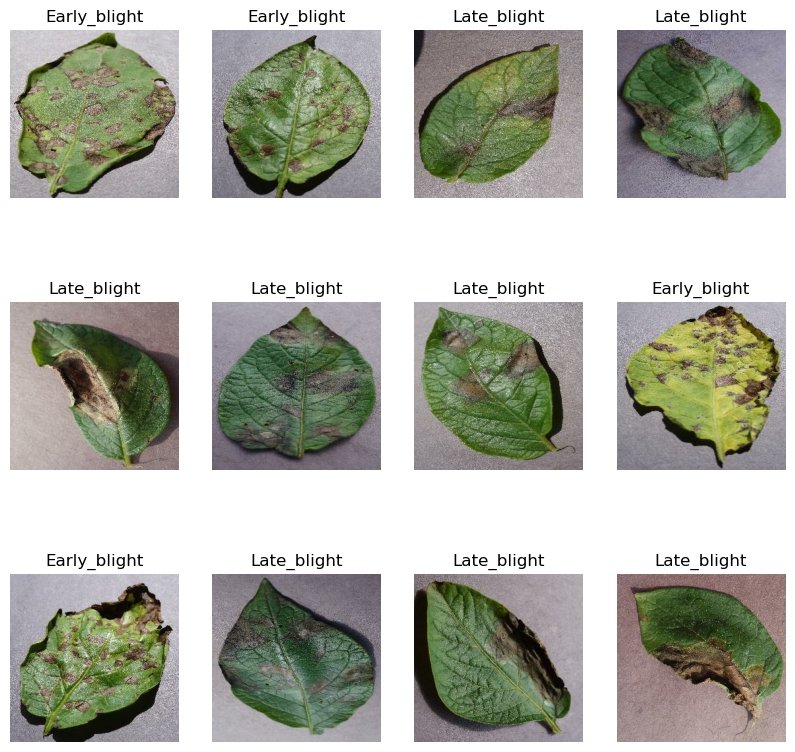

In [21]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# 3. Splitting data 
  

In [22]:
def split_data(dataset:tf.data.Dataset, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=1000):
    assert (train_size + val_size + test_size) == 1
    
    length = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
        train_size = int(length*train_size)
        val_size = int(length*val_size)
        test_size  = int(length*test_size)
    
    
        train_data = dataset.take(train_size)
        val_data = dataset.skip(train_size).take(val_size)
        test_data = dataset.skip(train_size+val_size).take(test_size)
        
        return [train_data, val_data, test_data]
        

In [23]:
train_data, val_data, test_data = split_data(dataset=dataset)

In [24]:
data_augmentation = models.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])
train_data_augmentation = train_data.map(
    lambda x, y : (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
len(dataset)

68

In [26]:
len(train_data)+ len(val_data)+ len(test_data)

66

# 4. Cache, Shuffle, and Prefetch the Dataset

In [27]:
train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 5. Model

## 5.1 Transfer Learning with Mobilenet V3 (small version)

In [15]:
model = MobileNetV3Small(
    include_top=True,
    weights=None,
    classes=len(class_names),
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

In [16]:
model.summary()

Model: "MobilenetV3small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 130, 130,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 130, 130,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 130, 130,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 131, 131,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 65, 65,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 65, 65,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 65, 65,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 65, 65,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 65, 65,    │        256 │ expanded_conv_sq

 Total params: 1,533,043 (5.85 MB)

 Trainable params: 1,520,931 (5.80 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [40]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
log_path = 'Logs/train_log.csv'
model_path = 'Model/v1'

In [45]:
csv_logger = keras.callbacks.CSVLogger(filename=log_path, separator=',', append=False, )
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
tensorboard = keras.callbacks.TensorBoard(log_dir='./Logs')

In [46]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
callbacks=[early_stopping, checkpoint, reduce_lr, tensorboard, csv_logger, lr_scheduler]

In [ ]:
history = model.fit(train_data, epochs=2, validation_data=val_data)

Epoch 1/2
14/54 ━━━━━━━━━━━━━━━━━━━━ 9:30 14s/step - accuracy: 0.4763 - loss: 5.2083

In [22]:
scores = model.evaluate(test_data)

6/6 [==============================] - 9s 503ms/step - loss: 1.4634e-06 - accuracy: 1.0000


# 6. Plotting the Accuracy and Loss Curves

In [24]:
history 

accuracy      loss  val_accuracy  val_loss
epoch                                            
0      0.511150  0.889374      0.541667  0.845447
1      0.711854  0.636295      0.851190  0.404063
2      0.840278  0.376169      0.937500  0.260909
3      0.892019  0.266059      0.942708  0.158425
4      0.896127  0.278459      0.901042  0.242005
5      0.933685  0.181480      0.932292  0.185279
6      0.947770  0.132415      0.963542  0.071690
7      0.959507  0.103982      0.968750  0.083042
8      0.935446  0.190734      0.937500  0.172462
9      0.967136  0.092544      0.958333  0.083910
10     0.965376  0.096212      0.947917  0.118282
11     0.971244  0.079155      0.947917  0.090643
12     0.977700  0.054619      0.989583  0.026169
13     0.981808  0.051652      0.984375  0.030042
14     0.988263  0.034721      0.994792  0.034747
15     0.977700  0.056847      0.989583  0.024052
16     0.974765  0.066470      1.000000  0.015410
17     0.984155  0.043624      1.000000  0.016016
18     0.997653  0.012816      0.994048  0.008156
19     0.993545  0.018736      0.994792  0.006870
20     0.990741  0.023214      0.989583  0.029978
21     0.984155  0.041346      0.989583  0.047995
22     0.984155  0.042543      1.000000  0.009558
23     0.997066  0.008334      1.000000  0.002048
24     1.000000  0.002653      1.000000  0.001540
25     1.000000  0.001030      1.000000  0.000706
26     1.000000  0.000651      1.000000  0.000569
27     1.000000  0.000333      1.000000  0.000148
28     1.000000  0.000192      1.000000  0.000176
29     1.000000  0.000140      1.000000  0.000139
30     1.000000  0.000114      1.000000  0.000095
31     1.000000  0.000102      1.000000  0.000096
32     1.000000  0.000094      1.000000  0.000100
33     1.000000  0.000094      1.000000  0.000120
34     1.000000  0.000072      1.000000  0.000067
35     1.000000  0.000073      1.000000  0.000085
36     1.000000  0.000059      1.000000  0.000025
37     1.000000  0.000052      1.000000  0.000055
38     1.000000  0.000052      1.000000  0.000043
39     1.000000  0.000047      1.000000  0.000038
40     1.000000  0.000041      1.000000  0.000034
41     1.000000  0.000040      1.000000  0.000022
42     1.000000  0.000035      1.000000  0.000025
43     1.000000  0.000035      1.000000  0.000034
44     1.000000  0.000030      1.000000  0.000029
45     1.000000  0.000032      1.000000  0.000036
46     1.000000  0.000024      1.000000  0.000023
47     1.000000  0.000027      1.000000  0.000048
48     1.000000  0.000025      1.000000  0.000018
49     1.000000  0.000023      1.000000  0.000020

In [27]:
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']


In [28]:
# Setup for plotting
labels = ['Training', 'Validation']
data_plot = [{
    'title' : 'Accuracy',
    'train_data' : train_acc,
    'val_data' : val_acc
    
}, {
    'title' : 'Loss',
    'train_data' : train_loss,
    'val_data' : val_loss
    
}
]

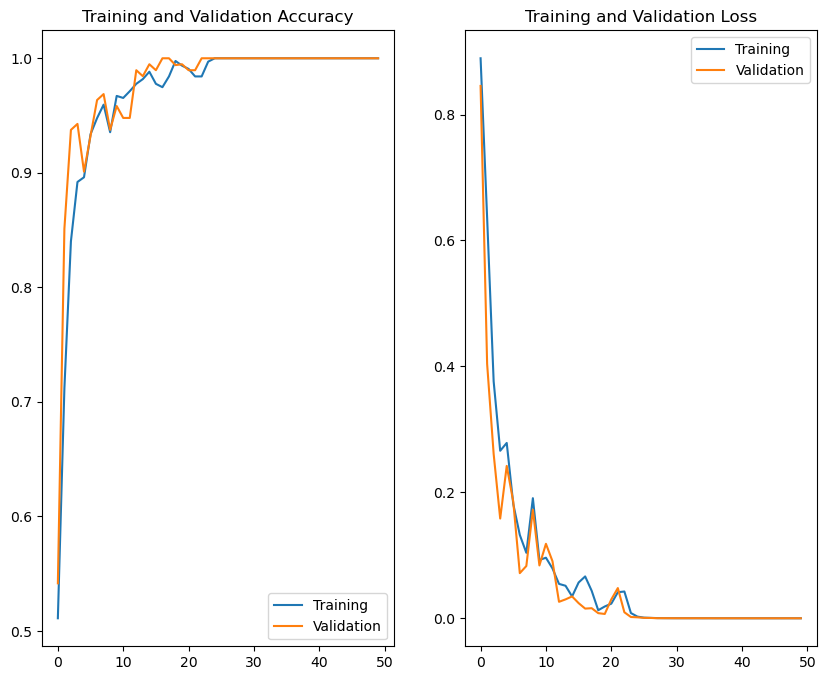

In [29]:
plt.figure(figsize=(10, 8))
for i in range(len(data_plot)):
    plt.subplot(1, 2, i+1)
    plt.plot(range(EPOCHS), data_plot[i]['train_data'], label=labels[0])
    plt.plot(range(EPOCHS), data_plot[i]['val_data'], label=labels[1])
    plt.title(f'Training and Validation {data_plot[i]["title"]}')
    plt.legend( loc='lower right' if i == 0 else 'upper right')
    

# 7. Run prediction on a sample image

First image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 641ms/step
predicted label: Potato___Late_blight


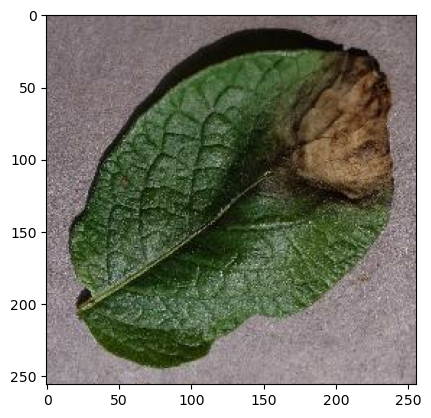

In [30]:
for img_batch, label_batch in test_data.take(1):
    img = img_batch[0].numpy().astype('uint8')
    label =label_batch[1].numpy()
    print("First image to predict")
    plt.imshow(img)
    print("actual label:",class_names[label])
    
    batch_prediction = model.predict(img_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# 8. Write function for inference

In [31]:
def predict_disease(mode :models.Sequential, img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img, 0)
    
    prediction = model.predict(img_arr)
    pred_class = class_names[np.argmax(prediction[0])]
    
    confidence = round(100*(np.max(prediction[0])), 2)
    
    return pred_class, confidence

## 8.1 Now run inference on few sample image

1/1 [==============================] - 0s 34ms/step


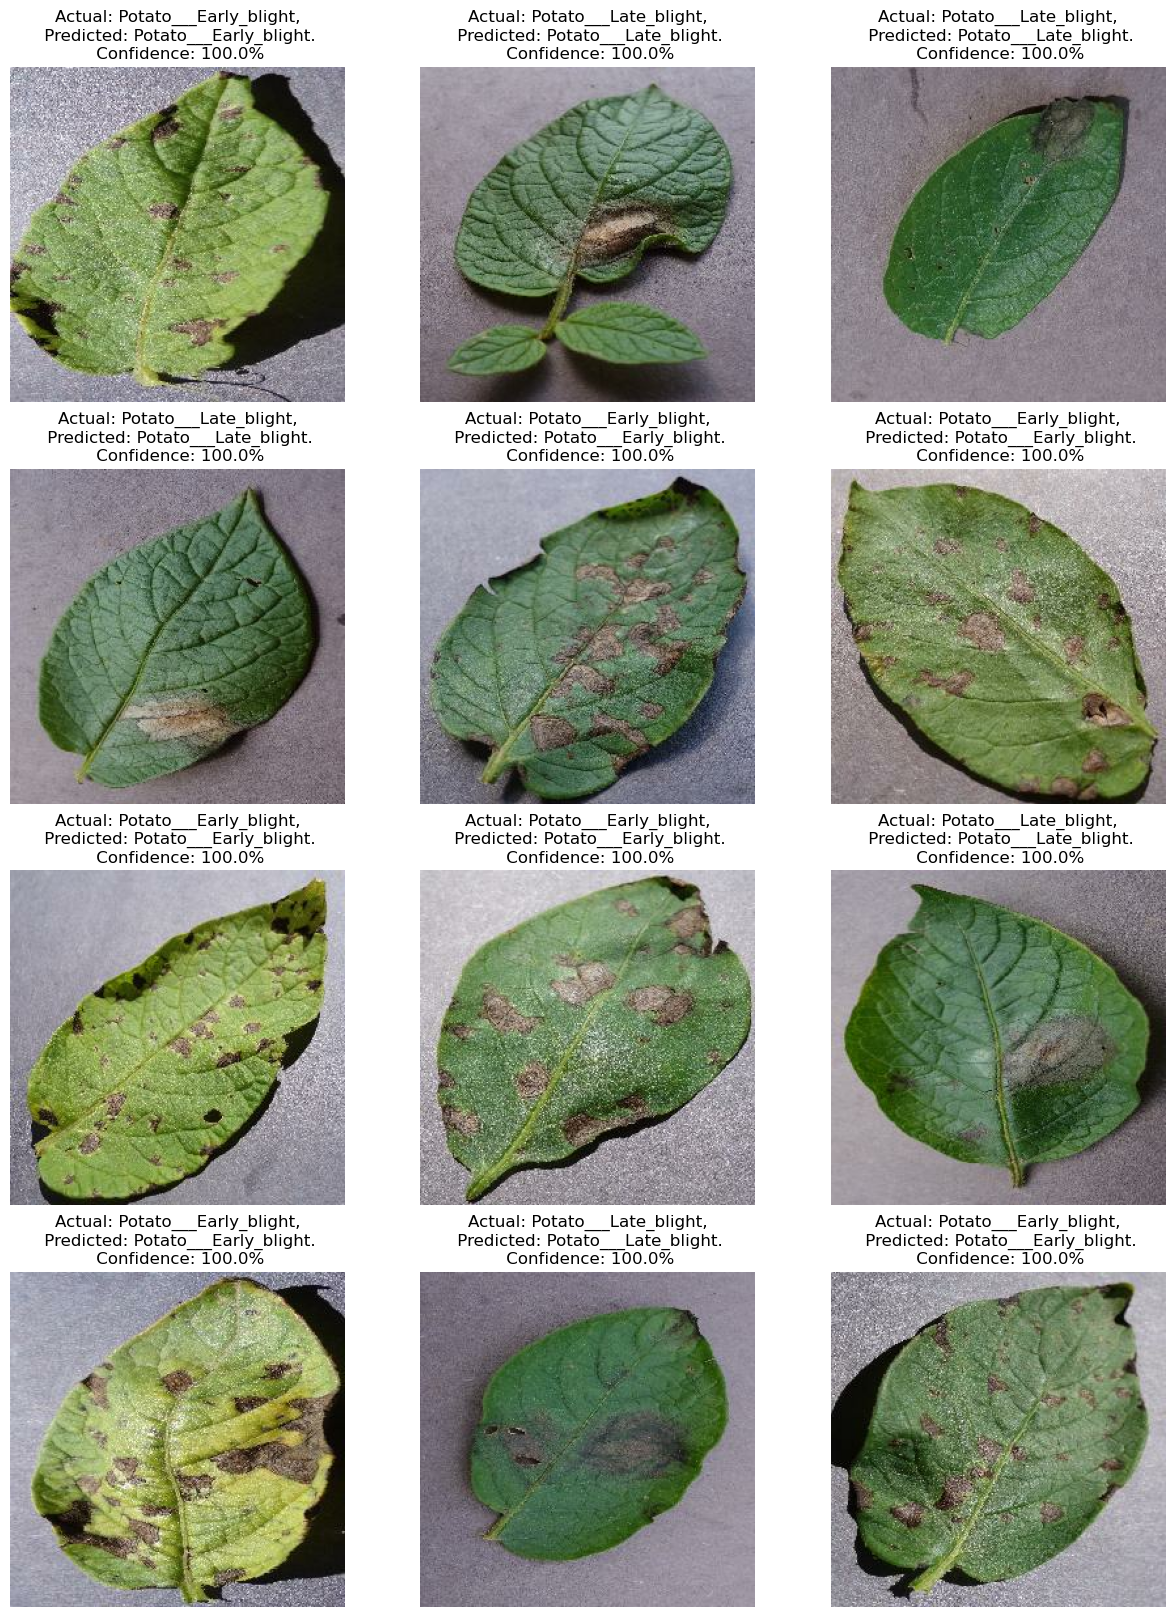

In [32]:
plt.figure(figsize=(15, 20))
for images, labels in test_data.take(1):
    for i in range(12):
        img_arr = images[i].numpy()
        plt.subplot(4, 3, i+1)
        plt.imshow(img_arr.astype("uint8"))
        
        pred_class, confidence = predict_disease(model, img_arr)
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {pred_class}.\n Confidence: {confidence}%")
        plt.axis('off')

# 9.Saving the Model 

In [35]:
model_version = max([int(i) for i in os.listdir("./Model") + [0]]) +1
model.save(f"./Model/{model_version}")

ValueError: invalid literal for int() with base 10: 'model_potato_disease.h5'

In [38]:
model.save("./potato_disease.h5")

C:\Users\ad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
